In [1]:
!pip install torch librosa scikit-learn soundfile transformers datasets numpy matplotlib pandas

  Using cached librosa-0.10.2.post1-py3-none-any.whl.metadata (8.6 kB)
  Using cached scikit_learn-1.6.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached soundfile-0.13.1-py2.py3-none-manylinux_2_28_x86_64.whl.metadata (16 kB)
  Using cached datasets-3.2.0-py3-none-any.whl.metadata (20 kB)
  Using cached matplotlib-3.10.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached audioread-3.0.1-py3-none-any.whl.metadata (8.4 kB)
  Using cached scipy-1.15.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached numba-0.61.0-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (2.8 kB)
  Using cached pooch-1.8.2-py3-none-any.whl.metadata (10 kB)
  Using cached soxr-0.5.0.post1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.me

In [30]:
import torch
from transformers import AutoProcessor, MusicgenForConditionalGeneration
from typing import Optional

#version_1

class MusicgenWithResiduals:
    def __init__(
        self,
        model_name: str = "facebook/musicgen-small",  # or "facebook/musicgen-medium", "facebook/musicgen-large"
        device: str = "cuda" if torch.cuda.is_available() else "cpu"
    ):
        print(f"Loading model {model_name} to {device}...")
        self.model = MusicgenForConditionalGeneration.from_pretrained(
            model_name,
            trust_remote_code=True,
            output_hidden_states=True
        ).to(device)

        print("Loading processor...")
        self.processor = AutoProcessor.from_pretrained(model_name)
        self.model.freeze_text_encoder()
        self.model.freeze_audio_encoder()

        self.device = device
        self.hidden_states = {}

        def hook_fn(module, input, output):
            #print("Hook triggered!")
            if hasattr(output, "hidden_states"):
                #print("Hidden states captured!")
                layer_names=[]
                if hasattr(self.model, 'decoder') and hasattr(self.model.decoder.model.decoder, 'layers'):
                    layer_names += [f"decoder.layer.{i}" for i in range(len(self.model.decoder.model.decoder.layers))]
                #print(len(output.hidden_states))
                self.hidden_states = {
                    layer_names[i]: output.hidden_states[i+1]
                    for i in range(len(layer_names))
                }
            else:
                print(f"Output structure: {type(output)} - {output}")

        self.model.decoder.model.decoder.register_forward_hook(hook_fn)
        print("Model ready!")

    def generate_with_residuals(
        self,
        text: str = None,
        audio: Optional[torch.Tensor] = None,
        sampling_rate: int= None,
        max_new_tokens: int = 10,
        temperature=1e-3,
        **kwargs
    ):

        self.model.decoder.config.output_hidden_states = True
        inputs = {}

        if text is None and audio is None:
            inputs = self.model.get_unconditional_inputs(num_samples=1)
        else:
            inputs = self.processor(
                text=text,
                audio=audio,
                sampling_rate=sampling_rate,
                padding=True,
                return_tensors="pt"
            ).to(self.device)

        # Move inputs to device
        #inputs = {k: v.to(self.device) for k, v in inputs.items()}

        # Generate
        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                output_hidden_states=True,
                return_dict_in_generate=True,
                max_new_tokens=max_new_tokens,
            )

        return {
            "audio_values": outputs.sequences,
            "residual_streams": self.hidden_states,  # Return the dictionary of hidden states
            "sampling_rate": self.model.config.audio_encoder.sampling_rate
        }


In [19]:
model = MusicgenWithResiduals()

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading model facebook/musicgen-small to cuda...


/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/transformers/models/encodec/modeling_encodec.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("padding_total", torch.tensor(kernel_size - stride, dtype=torch.int64), persistent=False)


Loading processor...
Model ready!


In [4]:
from datasets import load_dataset
gtzan = load_dataset("marsyas/gtzan", trust_remote_code=True)
print(gtzan)

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'genre'],
        num_rows: 999
    })
})


In [5]:
from datasets import load_dataset
fma_medium = load_dataset("benjamin-paine/free-music-archive-medium", trust_remote_code=True, streaming=True)
print(fma_medium)

Resolving data files:   0%|          | 0/44 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/44 [00:00<?, ?it/s]

IterableDatasetDict({
    train: IterableDataset({
        features: ['audio', 'title', 'url', 'artist', 'composer', 'lyricist', 'publisher', 'genres', 'tags', 'released', 'language', 'listens', 'artist_url', 'artist_website', 'album_title', 'album_url', 'license', 'copyright', 'explicit', 'instrumental', 'allow_commercial_use', 'allow_derivatives', 'require_attribution', 'require_share_alike'],
        num_shards: 44
    })
})


In [6]:
for i in fma_medium['train']:
    print(i['instrumental'])
    break

0


In [7]:
instrument2label_fma = fma_medium['train'].features['instrumental']
print(instrument2label_fma.int2str(1))

Yes


In [8]:
print(gtzan['train'].features['genre'].int2str.__doc__)

Conversion `integer` => class name `string`.

        Regarding unknown/missing labels: passing negative integers raises `ValueError`.

        Example:

        ```py
        >>> from datasets import load_dataset
        >>> ds = load_dataset("rotten_tomatoes", split="train")
        >>> ds.features["label"].int2str(0)
        'neg'
        ```
        


In [9]:
id2label_fn = gtzan['train'].features['genre'].int2str
id2label_fn(gtzan['train'][0]['genre'])

'blues'

In [10]:
dir(fma_medium['train'].features['genres'])

['__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__match_args__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_type',
 'dtype',
 'feature',
 'id',
 'length',
 'pa_type']

In [11]:
id2label_fma = fma_medium['train'].features['genres'].feature
#for i in fma_medium['train']:
#    print(id2label_fma(i['genres']))
#    break
print(id2label_fma.int2str(58))

Folk


In [12]:
print(fma_medium['train'].features['genres'].feature.__doc__)

Feature type for integer class labels.

    There are 3 ways to define a `ClassLabel`, which correspond to the 3 arguments:

     * `num_classes`: Create 0 to (num_classes-1) labels.
     * `names`: List of label strings.
     * `names_file`: File containing the list of labels.

    Under the hood the labels are stored as integers.
    You can use negative integers to represent unknown/missing labels.

    Args:
        num_classes (`int`, *optional*):
            Number of classes. All labels must be < `num_classes`.
        names (`list` of `str`, *optional*):
            String names for the integer classes.
            The order in which the names are provided is kept.
        names_file (`str`, *optional*):
            Path to a file with names for the integer classes, one per line.

    Example:

    ```py
    >>> from datasets import Features, ClassLabel
    >>> features = Features({'label': ClassLabel(num_classes=3, names=['bad', 'ok', 'good'])})
    >>> features
    {'label': 

In [13]:
genre_map = {}
for i in range(10):
    genre_map[i] = id2label_fn(i)
print(genre_map)

{0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


In [14]:
#use this function for dealing with GTZAN

import numpy as np
import librosa

def process_with_residuals(model, data, count):
    target_sr = 32000
    audio = data['audio']
    sr = audio['sampling_rate']
    genre = id2label_fn(data['genre'])
    prompt = f"Generate {genre} music continuing the given audio"
    #print(audio['array'].shape)
    audio['array'] = librosa.resample(y=audio['array'], orig_sr=sr, target_sr=target_sr)
    audio_segments = [audio['array'][i*target_sr:(i+10)*target_sr] for i in range(5, int(audio['array'].shape[0]//target_sr), 5)]
    result = []
    for segment in audio_segments:
        #print(f"Segment shape: {segment.shape} segment type: {type(segment)}")
        outputs = model.generate_with_residuals(
            text=prompt,
            audio=segment,
            sampling_rate = target_sr,
            max_new_tokens=512,
            guidance_scale=3.0,
            do_sample=True
        )
        
        # Get the residual stream from the last layer
        residual = np.array([outputs['residual_streams'][i].detach().cpu().numpy() for i in outputs['residual_streams']])
        
        # Create result dictionary with all original features and new data
        result.append({
            'genre': genre,
            'generated_audio': outputs['audio_values'].detach().cpu().numpy(),
            'residual_stream': residual,
            'sampling_rate': outputs['sampling_rate'],
            'prompt_used': prompt
        })
    
    return result

In [15]:
#use this function for dealing with FMA Medium - 
#both these cells try to do the same thing
#just that the dataset structure is slightly different

#use this function for dealing with GTZAN

import numpy as np
import librosa

def process_with_residuals(model, data, count):
    target_sr = 32000
    audio = data['audio']
    sr = audio['sampling_rate']
    genre = id2label_fma.int2str(data['genres'][0])
    prompt = f"Generate {genre} music continuing the given audio"
    #print(audio['array'].shape)
    audio['array'] = librosa.resample(y=audio['array'], orig_sr=sr, target_sr=target_sr)
    audio_segments = [audio['array'][i*target_sr:(i+10)*target_sr] for i in range(0, int(audio['array'].shape[0]//target_sr), 10)]
    result = []
    for segment in audio_segments:
        #print(f"Segment shape: {segment.shape} segment type: {type(segment)}")
        outputs = model.generate_with_residuals(
            text=prompt,
            audio=segment,
            sampling_rate = target_sr,
            max_new_tokens=512,
            guidance_scale=3.0,
            do_sample=True
        )
        
        # Get the residual stream from the last layer
        residual = np.array([outputs['residual_streams'][i].detach().cpu().numpy() for i in outputs['residual_streams']])
        
        # Create result dictionary with all original features and new data
        result.append({
            'genre': genre,
            'generated_audio': outputs['audio_values'].detach().cpu().numpy(),
            'residual_stream': residual,
            'sampling_rate': outputs['sampling_rate'],
            'prompt_used': prompt
        })
    
    return result

In [16]:
del model

In [17]:
import re

def sanitize_string(s):
    return re.sub(r'[^a-zA-Z0-9]', '', s)

In [20]:
# Create a directory to save the processed data
import os
import numpy as np
save_dir = "gtzan_with_temp_long"
os.makedirs(save_dir, exist_ok=True)
print('Made folder')
for idx, data in enumerate(gtzan['train']):
        #try:
    #if data['instrumental']:
            genre = sanitize_string(id2label_fn(data['genre']))
            if genre=='classical':
                name = f"{genre}_{idx}"
                processed_data = process_with_residuals(model, data, idx)
                for result in range(len(processed_data)):
                    print(f"processed {name}_{result}")
                    # Save using numpy's save function
                    save_path = os.path.join(save_dir, f"{name}_{result}.npz")
                    np.savez(
                        save_path,
                        **processed_data[result]
                    )
                    
                    if idx % 10 == 0:  # Print progress every 10 items
                        print(f"Processed {idx} samples")
            
        #except Exception as e:
        #    print(f"Error processing chord {idx}: {e}")
        #    continue

Made folder


KeyError: 'genres'

In [21]:
# Create a directory to save the processed data
import os
import numpy as np
save_dir = "gtzan_with_temp_long"
os.makedirs(save_dir, exist_ok=True)
print('Made folder')
for idx, data in enumerate(gtzan['train']):
        #try:
    #if data['instrumental']:
            genre = sanitize_string(id2label_fn(data['genre']))
            if idx > 923:
                if genre=='rock':
                    name = f"{genre}_{idx}"
                    processed_data = process_with_residuals(model, data, idx)
                    for result in range(len(processed_data)):
                        print(f"processed {name}_{result}")
                        # Save using numpy's save function
                        save_path = os.path.join(save_dir, f"{name}_{result}.npz")
                        np.savez(
                            save_path,
                            **processed_data[result]
                        )
                        
                        if idx % 10 == 0:  # Print progress every 10 items
                            print(f"Processed {idx} samples")
            
        #except Exception as e:
        #    print(f"Error processing chord {idx}: {e}")
        #    continue

Made folder


KeyError: 'genres'

In [ ]:
print(1)

In [2]:
import os
import numpy as np
import pandas as pd

# Directory containing processed chord files
save_dir = 'gtzan_with_temp_long'
# Initialize a list to hold the data


def get_data(save_dir):
    data = []
    # Iterate through each file in the directory
    for filename in os.listdir(save_dir):
        if filename.endswith('.npz'):
            # Load the file
            loaded_file = dict(np.load(os.path.join(save_dir, filename), allow_pickle=True))
            
            # Reshape the residual streams
            if not data:
                print(loaded_file['residual_stream'].shape)
            residual_unconditional = loaded_file['residual_stream'].reshape(24, 2, 1024)[:, 1, :]
            residual_conditional = loaded_file['residual_stream'].reshape(24, 2, 1024)[:, 0, :]
            
            # Extract chord type and inversion
            genre = loaded_file['genre']
            
            # Create a dictionary for the current file's data
            file_data = {
                'filename': filename,
                'genre': genre,
            }
            
            # Add residuals to the dictionary
            for layer in range(24):
                file_data[f'residual_conditional_{layer + 1}'] = residual_conditional[layer, :]
                file_data[f'residual_unconditional_{layer + 1}'] = residual_unconditional[layer, :]
            
            # Append the file data to the list
            data.append(file_data)
    return data

# Create a DataFrame from the collected data
data = get_data(save_dir)
df = pd.DataFrame(data)
df.head()

(24, 2, 1, 1024)


,filename,genre,residual_conditional_1,residual_unconditional_1,residual_conditional_2,residual_unconditional_2,residual_conditional_3,residual_unconditional_3,residual_conditional_4,residual_unconditional_4,...,residual_conditional_20,residual_unconditional_20,residual_conditional_21,residual_unconditional_21,residual_conditional_22,residual_unconditional_22,residual_conditional_23,residual_unconditional_23,residual_conditional_24,residual_unconditional_24
0,classical_100_0.npz,classical,"[0.8765169, 1.3051283, 0.5713105, -0.5922, 0.1...","[0.8715515, 1.3028514, 0.5635295, -0.6012915, ...","[0.6019123, 1.2878541, 0.7647358, 0.21650824, ...","[0.6074547, 1.2860225, 0.7622152, 0.22340178, ...","[0.23056667, 0.19586623, 0.31653067, 0.2218036...","[0.23531927, 0.19883707, 0.32136968, 0.2285504...","[0.26585168, 0.2443686, 0.21851772, 0.18757254...","[0.25839612, 0.23289105, 0.2139768, 0.19731176...",...,"[0.12443872, 0.17050168, 0.10614833, 0.2143153...","[0.114680514, 0.16313215, 0.1381813, 0.1939088...","[0.17471145, 0.10377824, 0.11551076, 0.2483970...","[0.18427694, 0.1032343, 0.14202851, 0.23688614...","[0.10006359, 0.16789928, 0.13707937, 0.1905126...","[0.10580403, 0.17586377, 0.16431807, 0.1735320...","[0.10128893, 0.422853, 0.16122228, 0.19499846,...","[0.10535018, 0.42358923, 0.1730006, 0.1637116,...","[-0.5125365, 1.6124086, 0.039702956, -0.103515...","[-0.4359003, 1.4882603, 0.22749807, -0.1014558..."
1,classical_100_1.npz,classical,"[0.87654376, 1.3006002, 0.56667686, -0.5371668...","[0.8715876, 1.2983202, 0.5588901, -0.5462357, ...","[0.6131314, 1.2875757, 0.7681989, 0.24559638, ...","[0.62234, 1.2833316, 0.7650793, 0.25324714, 0....","[0.22052898, 0.24628073, 0.26074302, 0.2360847...","[0.21874262, 0.24891776, 0.27050307, 0.2465609...","[0.23225358, 0.25406313, 0.14833587, 0.2439586...","[0.235481, 0.25882766, 0.13962485, 0.24138427,...",...,"[0.09703977, 0.13463776, 0.10740838, 0.1065317...","[0.09040022, 0.12034564, 0.12343526, 0.0801761...","[0.13701905, 0.09751303, 0.10604454, 0.0675440...","[0.13375041, 0.08821978, 0.11410065, 0.0544599...","[0.104617015, 0.18662462, 0.121948406, 0.09249...","[0.11524538, 0.18511926, 0.12244941, 0.0785703...","[0.086738765, 0.57440627, 0.12455101, 0.150583...","[0.10613447, 0.57043034, 0.115950584, 0.127605...","[-0.6465887, 2.2752984, -0.15930595, -0.133585...","[-0.67868996, 2.16433, -0.12949245, -0.1562697..."
2,classical_100_2.npz,classical,"[0.8795066, 1.3068825, 0.563421, -0.6156649, 0...","[0.8745423, 1.3046011, 0.5556421, -0.6247678, ...","[0.59907234, 1.2940484, 0.7700028, 0.22724557,...","[0.60521495, 1.2908167, 0.7676707, 0.2369057, ...","[0.23722553, 0.2716858, 0.2195059, 0.1461118, ...","[0.24561545, 0.27231914, 0.22644436, 0.1559057...","[0.25587144, 0.22751747, 0.097103685, 0.175068...","[0.252504, 0.23622775, 0.099668324, 0.18868507...",...,"[0.060874015, 0.19092235, 0.1251432, 0.2376834...","[0.063828275, 0.18863648, 0.13412645, 0.219968...","[0.05493402, 0.10825489, 0.10531945, 0.2607659...","[0.07625465, 0.10817008, 0.11056904, 0.2481176...","[0.08599696, 0.14601192, 0.15029329, 0.3242260...","[0.11625723, 0.15298505, 0.16074765, 0.3188271...","[0.068721175, 0.43447042, 0.18478753, 0.354937...","[0.08998142, 0.43354863, 0.19019672, 0.3295460...","[-1.5692388, 1.6288836, 1.5125129, 0.8781717, ...","[-1.4035058, 1.5432076, 1.5874563, 0.9115719, ..."
3,classical_100_3.npz,classical,"[0.8757181, 1.3106121, 0.5683592, -0.5918981, ...","[0.87075967, 1.3083338, 0.56058425, -0.6009707...","[0.60320175, 1.2913094, 0.7686763, 0.21040258,...","[0.612319, 1.2892975, 0.7662893, 0.2215895, 0....","[0.19672522, 0.22245088, 0.30567357, 0.1480141...","[0.20452456, 0.22750822, 0.31415194, 0.1555171...","[0.17703488, 0.25983173, 0.12734422, 0.1293094...","[0.17891566, 0.26798108, 0.12447843, 0.1292824...",...,"[0.130025, 0.20654872, 0.23929763, 0.2114554, ...","[0.12569198, 0.20284393, 0.2408135, 0.19755071...","[0.10399909, 0.14017645, 0.16150875, 0.3056425...","[0.110625245,

In [3]:
df = df.sample(frac=1)
df.head()

,filename,genre,residual_conditional_1,residual_unconditional_1,residual_conditional_2,residual_unconditional_2,residual_conditional_3,residual_unconditional_3,residual_conditional_4,residual_unconditional_4,...,residual_conditional_20,residual_unconditional_20,residual_conditional_21,residual_unconditional_21,residual_conditional_22,residual_unconditional_22,residual_conditional_23,residual_unconditional_23,residual_conditional_24,residual_unconditional_24
173,classical_134_3.npz,classical,"[0.8795153, 1.3042308, 0.5680939, -0.5835088, ...","[0.874599, 1.3019546, 0.5602961, -0.59252846, ...","[0.6338806, 1.2928269, 0.77581906, 0.19939947,...","[0.64333683, 1.2907645, 0.7722596, 0.21289617,...","[0.20618904, 0.16535212, 0.26688978, 0.1777960...","[0.21496156, 0.16966674, 0.2733744, 0.18923318...","[0.20815945, 0.2917309, 0.26029408, 0.16878808...","[0.19964446, 0.2970418, 0.25258783, 0.172156, ...",...,"[0.0047971606, 0.16902734, 0.14170153, 0.17027...","[-0.004984483, 0.15528937, 0.14605783, 0.15684...","[0.1019894, 0.11319893, 0.15104851, 0.24819422...","[0.09831762, 0.1049981, 0.14110623, 0.24195063...","[0.1103751, 0.15934701, 0.15035774, 0.19820017...","[0.1218152, 0.15944009, 0.1471156, 0.19292721,...","[0.07024212, 0.49779966, 0.2543764, 0.24711087...","[0.08136456, 0.49880767, 0.2486729, 0.22601403...","[0.07113918, 1.7931118, 3.2991254, -0.92312944...","[-0.043992035, 1.695296, 3.2172592, -0.8918662..."
788,rock_957_1.npz,rock,"[0.8745894, 1.3038096, 0.5612658, -0.5941216, ...","[0.86974794, 1.301379, 0.5539595, -0.6027256, ...","[0.59747833, 1.2952423, 0.77721715, 0.23987961...","[0.60952044, 1.289115, 0.7714388, 0.2545153, 0...","[0.16644391, 0.2918158, 0.23772806, 0.19999656...","[0.17319384, 0.2923466, 0.23924966, 0.21170926...","[0.20233902, 0.2387206, 0.22751613, 0.22343569...","[0.20853657, 0.21798867, 0.22012314, 0.2326998...",...,"[0.07032645, 0.14419124, 0.06651575, 0.1555480...","[0.06351099, 0.14281282, 0.08864052, 0.1467738...","[0.09193566, 0.10972767, 0.01292279, 0.1509295...","[0.08621976, 0.1189515, 0.03558313, 0.15538327...","[0.10902883, 0.20808963, 0.07902773, 0.2084105...","[0.10809396, 0.2123037, 0.099228114, 0.2030831...","[0.011903942, 0.4430586, 0.11299569, 0.2034464...","[0.020447515, 0.45333803, 0.11872399, 0.192468...","[-1.5963453, 1.484328, 1.0651861, -1.0340774, ...","[-1.5253015, 1.4808806, 1.110378, -0.9788901, ..."
288,classical_157_3.npz,classical,"[0.8820428, 1.3040199, 0.566338, -0.6147582, 0...","[0.8770876, 1.3017333, 0.55855584, -0.62386966...","[0.6372365, 1.2926421, 0.7748126, 0.20508409, ...","[0.6466594, 1.2874848, 0.77103496, 0.21948871,...","[0.23452538, 0.1471104, 0.24239635, 0.22315207...","[0.24552554, 0.1410566, 0.2608177, 0.23432872,...","[0.26795512, 0.16532804, 0.23705168, 0.1406507...","[0.26060432, 0.16500944, 0.24032655, 0.1475480...",...,"[0.09411215, 0.16019313, 0.2493399, 0.18302417...","[0.08380326, 0.15808864, 0.25251144, 0.1824829...","[0.13665721, 0.0816206, 0.17849314, 0.21107131...","[0.13125204, 0.08052145, 0.17989647, 0.2173952...","[0.15721603, 0.14539316, 0.13781777, 0.1909714...","[0.16228084, 0.15726331, 0.13698763, 0.1938260...","[0.14387153, 0.43308824, 0.14010963, 0.2911057...","[0.15589976, 0.45319006, 0.12767383, 0.2800324...","[-0.8563916, 1.404787, 1.1673661, 0.13344099, ...","[-0.57526535, 1.5006049, 1.0655465, 0.27568248..."
102,classical_120_2.npz,classical,"[0.87196857, 1.305637, 0.56560767, -0.5822347,...","[0.8669981, 1.3033606, 0.55782825, -0.59130585...","[0.5942163, 1.2892954, 0.7676964, 0.20463854, ...","[0.6016037, 1.2869254, 0.76471585, 0.21976039,...","[0.23024312, 0.16194308, 0.24736172, 0.1840878...","[0.23515964, 0.16032258, 0.25671628, 0.1947112...","[0.27278247, 0.3129108, 0.18615386, 0.24517924...","[0.27253896, 0.3125028, 0.17477489, 0.24650455...",...,"[0.10660417, 0.25441965, 0.24752945, 0.0925283...","[0.091711335, 0.25189197, 0.24837048, 0.087833...","[0.17890683, 0.18008849, 0.28208995, 0.1274110...","[0.1706151, 0.1

In [ ]:
rock = df[df['genre']=='rock']
classical = df[df['genre']=='classical']

In [ ]:
df['genre'] = df['genre'].replace({'blues': 'jazz', 'metal': 'rock' , 'hiphop' : 'pop' })

In [ ]:
l = np.array([str(i.item()) for i in df['genre']])
d = []
for i in l:
    if i not in d:
        d.append(i)
d

In [ ]:
inv_genre_map = {genre_map[i]: i for i in genre_map}
inv_genre_map

In [4]:
inv_genre_map = {'classical': -1, 'rock': 1}

In [ ]:
df['genre'][0]

In [5]:
df['label'] = df['genre'].apply(lambda x: inv_genre_map[x.item()])

In [6]:
import os
import numpy as np
import pandas as pd

# Directory containing processed chord files
save_dir = 'fma_medium'

# Function to load .npz files with specific labels
def get_data(save_dir):
    data = []
    # Iterate through each file in the directory
    for filename in os.listdir(save_dir):
        if filename.endswith('.npz'):
            # Determine genre label
            if any(keyword in filename.lower() for keyword in ["classical", "chamber"]):
                label = "classical"
            elif any(keyword in filename.lower() for keyword in ["metal", "rock"]):
                label = "rock"
            else:
                continue  # Ignore other genres
            
            # Load the file
            loaded_file = dict(np.load(os.path.join(save_dir, filename), allow_pickle=True))
            
            # Reshape the residual streams
            if not data:
                print("Residual shape:", loaded_file['residual_stream'].shape)
            residual_unconditional = loaded_file['residual_stream'].reshape(24, 2, 1024)[:, 1, :]
            residual_conditional = loaded_file['residual_stream'].reshape(24, 2, 1024)[:, 0, :]
            
            # Create a dictionary for the current file's data
            file_data = {
                'filename': filename,
                'genre': loaded_file['genre'],  # Keeping original genre if needed
                'label': label  # Assigned label based on filename
            }
            
            # Add residuals to the dictionary
            for layer in range(24):
                file_data[f'residual_conditional_{layer + 1}'] = residual_conditional[layer, :]
                file_data[f'residual_unconditional_{layer + 1}'] = residual_unconditional[layer, :]
            
            # Append the file data to the list
            data.append(file_data)
    
    return data

# Create a DataFrame from the collected data
data = get_data(save_dir)
fma_df = pd.DataFrame(data)
fma_df.head()  # Display first few rows


Residual shape: (24, 2, 1, 1024)


,filename,genre,label,residual_conditional_1,residual_unconditional_1,residual_conditional_2,residual_unconditional_2,residual_conditional_3,residual_unconditional_3,residual_conditional_4,...,residual_conditional_20,residual_unconditional_20,residual_conditional_21,residual_unconditional_21,residual_conditional_22,residual_unconditional_22,residual_conditional_23,residual_unconditional_23,residual_conditional_24,residual_unconditional_24
0,Rock_96_0.npz,Rock,rock,"[1.0466661, -0.58569086, 0.9656643, 0.3584233,...","[1.041538, -0.5878071, 0.95810795, 0.349821, -...","[0.69775, -0.6273826, 0.9353639, 0.23760545, 0...","[0.6939877, -0.6319696, 0.93285567, 0.25677425...","[0.30697986, 0.25218174, 0.36788762, 0.2719670...","[0.31845433, 0.25858852, 0.37069684, 0.2830425...","[0.32925454, 0.22180937, 0.31613234, 0.2059690...",...,"[0.20604044, 0.23424664, 0.15465558, 0.0737488...","[0.19175857, 0.23235269, 0.15423325, 0.0838197...","[0.26201144, 0.26714075, 0.14830002, 0.1375717...","[0.24214238, 0.2604666, 0.14876164, 0.15069638...","[0.2053627, 0.23216565, 0.09111015, 0.14778504...","[0.20924665, 0.22936846, 0.090353414, 0.151359...","[0.18773547, 0.5947029, 0.1277577, 0.17593914,...","[0.1944741, 0.60281575, 0.1188711, 0.18188514,...","[0.3980146, 3.0512235, 1.1219611, -0.7355472, ...","[0.24003758, 2.997928, 1.0731148, -0.57101184,..."
1,Rock_96_1.npz,Rock,rock,"[1.0507417, -0.6005354, 0.9632375, 0.2981135, ...","[1.0456179, -0.6026627, 0.9556649, 0.28949562,...","[0.711866, -0.6368618, 0.9200722, 0.2118064, 0...","[0.7107748, -0.63887, 0.91699785, 0.22733244, ...","[0.24098817, 0.2187515, 0.23707281, 0.24392231...","[0.24384819, 0.22900645, 0.24390735, 0.2597963...","[0.31234956, 0.12237044, 0.41615015, 0.1882540...",...,"[0.16544946, 0.22579585, 0.2861961, 0.14390197...","[0.15729515, 0.21203044, 0.29413322, 0.1330432...","[0.21170986, 0.28215414, 0.24254651, 0.1135729...","[0.19931269, 0.29189247, 0.2622286, 0.10681932...","[0.16771111, 0.296619, 0.117357925, 0.18405353...","[0.17369516, 0.28602377, 0.13027112, 0.1677387...","[0.19943053, 0.626352, 0.18725531, 0.17701203,...","[0.21408173, 0.61855304, 0.18478619, 0.154866,...","[-0.083322525, 2.7918444, 0.586565, 0.3709207,...","[0.09572701, 2.728831, 0.41502568, 0.26790923,..."
2,Rock_96_2.npz,Rock,rock,"[0.7233, -0.472874, 1.3539903, -0.5581348, 0.5...","[0.71829003, -0.47500825, 1.3463855, -0.566730...","[0.5701301, -0.49477077, 1.4065074, 0.25804478...","[0.56623214, -0.49608847, 1.4026136, 0.2757437...","[0.32920516, 0.26133433, 0.27172157, 0.3638259...","[0.32641423, 0.258408, 0.27163887, 0.37559995,...","[0.38217372, 0.24146765, 0.24693868, 0.2660355...",...,"[0.2280556, 0.18231651, 0.20232822, 0.22921073...","[0.22662894, 0.18320838, 0.20775916, 0.2273258...","[0.24513629, 0.30122924, 0.21760821, 0.2278479...","[0.2380131, 0.30840424, 0.22228578, 0.22975442...","[0.24092294, 0.30351532, 0.18462184, 0.2216055...","[0.23853996, 0.30432722, 0.18797413, 0.2166648...","[0.26810944, 0.55613303, 0.2843358, 0.27369723...","[0.27181783, 0.5649178, 0.27192685, 0.26121682...","[1.03205, 2.6552029, 2.177057, 0.54372, 1.9946...","[1.0050085, 2.5888684, 2.03903, 0.5576673, 1.9..."
3,Classical_846_0.npz,Classical,classical,"[1.0575502, -0.5876264, 0.97202265, 0.30099764...","[1.0524089, -0.58956325, 0.9640813, 0.29230702...","[0.6692958, -0.6308029, 0.92665595, 0.24335307...","[0.68297124, -0.63320774, 0.9228103, 0.2605444...","[0.22913094, 0.2979999, 0.2542483, 0.2192996, ...","[0.24662101, 0.30641115, 0.25744656, 0.2307028...","[0.28970528, 0.29278663, 0.26593423, 0.2335304...",...,"[0.16406833, 0.22175023, 0.23075998, 0.1981630...","[0.16177781, 0.22536686, 0.22756189, 0.1823734...","[0.12715043, 0.2200982, 0.1892843, 0.25928912,...","[0.12574096, 0.22746086, 0.1890243, 0.25080213...","[0.21364701, 0.21071096, 0.18915644, 0.2502132...","[0.21863303, 0.20834313, 0.17569435, 0.2617614...","[0.2025297, 0.4581675, 0.24898905, 0.28627825,...","[0.21720144, 0.45819378, 0.21668229, 0.2

In [ ]:
fma_df.shape

In [ ]:
fma_df.columns

In [7]:
fma_df['label'] = fma_df['label'].apply(lambda x: inv_genre_map[x])
cdf = pd.concat([df, fma_df])
cdf.shape

(1777, 51)

In [81]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from torch.utils.data import TensorDataset, DataLoader

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define your linear probe (a single linear layer without bias)
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.linear = nn.Linear(input_size, num_classes, bias=False)  # No bias

    def forward(self, x):
        return self.linear(x)  # Raw dot products

def sign(x):
    return torch.where(x < 0, -1, 1)

# Parameters and column names
layers = list(range(1, 25))  # Layers 1 to 24
acc_list = []
loss_list = []
vloss_list = []
weights_dict = {i:0 for i in range(1, len(layers)+1)}
print(weights_dict)
for i in range(1, len(layers)+1):
    
    cond_col = f"residual_conditional_{i}"
    uncond_col = f"residual_unconditional_{i}"
    num_classes = 1  # For example, 10 classes
    input_size = 1024
    X_cond = normalize(np.stack(cdf[cond_col].values), norm='l2')  # Shape: (N, 1024)
    y = cdf["label"].values.astype(np.float32)  # Convert labels to float for MSELoss
    
    # Split data into training and testing sets
    X_cond_train, X_cond_test, y_cond_train, y_cond_test = train_test_split(
        X_cond, y, test_size=0.15, random_state=42, shuffle=True
    )
    
    # Convert features and labels to PyTorch tensors
    X_cond_train = torch.tensor(X_cond_train, dtype=torch.float32).to(device)
    X_cond_test  = torch.tensor(X_cond_test, dtype=torch.float32).to(device)
    y_cond_train = torch.tensor(y_cond_train, dtype=torch.float32).to(device)
    y_cond_test  = torch.tensor(y_cond_test, dtype=torch.float32).to(device)
    
    # Ensure labels have the correct shape (N, 1) since MSELoss expects predictions to match the shape of targets
    y_cond_train = y_cond_train.unsqueeze(1)
    y_cond_test = y_cond_test.unsqueeze(1)
    
    # Define mini-batch size and create DataLoaders
    batch_size = 1024
    
    def get_loader(X, y, batch_size):
        dataset = TensorDataset(X, y)
        return DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Create loaders for one of the conditions (repeat similarly for the other)
    cond_train_loader = get_loader(X_cond_train, y_cond_train, batch_size)
    cond_test_loader  = get_loader(X_cond_test, y_cond_test, batch_size)
    
    # Initialize the model, optimizer, and MSE loss.
    model = SimpleNN(input_size=input_size, num_classes=num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    loss_fn = nn.MSELoss()
    
    num_epochs = 250
    
    # Training loop using MSELoss with one-hot targets
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in cond_train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)  # Raw outputs: [batch_size, num_classes]
            # Optionally, you could apply a softmax if you want the outputs to behave like probabilities:
            # outputs = torch.softmax(outputs, dim=1)
            loss = loss_fn(outputs, y_batch)  # Compare to one-hot target
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
        if (epoch + 1) % 10== 0:
            epoch_loss = running_loss / len(cond_train_loader.dataset)
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.8f}")
    loss_list.append(epoch_loss) #Loss at the end of training loop
    # Evaluation: compute validation loss and accuracy
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    
    with torch.no_grad():
        for X_batch, y_batch in cond_test_loader:
            outputs = model(X_batch)
            # Compute the batch loss (MSELoss)
            loss = loss_fn(outputs, y_batch)
            # Multiply by the batch size to accumulate the total loss
            val_loss += loss.item() * X_batch.size(0)
            
            # Apply sign function to threshold the outputs to -1 or 1
            predicted = sign(outputs)
            total += y_batch.size(0)
            correct += torch.eq(predicted, y_batch).sum().item()
            # Optional: print the actual and predicted values for each batch
            #print("Actual:", y_batch.cpu().numpy().squeeze(), "Predicted:", predicted.cpu().numpy().squeeze())
    
    # Calculate average loss and accuracy over the validation set
    val_loss /= total
    accuracy = correct / total
    
    print(f"Accuracy (Conditional): {accuracy:.8f}")
    print(f"Validation Loss (Conditional): {val_loss:.8f}")

    acc_list.append(accuracy)
    vloss_list.append(val_loss)
    # Store the full weight matrix instead of flattening
    weights_dict[i] = model.linear.weight.detach().cpu().numpy()


{1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0}
Epoch [10/250], Loss: 0.95444815
Epoch [20/250], Loss: 0.92809738
Epoch [30/250], Loss: 0.90180004
Epoch [40/250], Loss: 0.87618746
Epoch [50/250], Loss: 0.85157648
Epoch [60/250], Loss: 0.82834509
Epoch [70/250], Loss: 0.80716091
Epoch [80/250], Loss: 0.78675456
Epoch [90/250], Loss: 0.76741626
Epoch [100/250], Loss: 0.74904274
Epoch [110/250], Loss: 0.73171799
Epoch [120/250], Loss: 0.71544711
Epoch [130/250], Loss: 0.69994761
Epoch [140/250], Loss: 0.68610075
Epoch [150/250], Loss: 0.67216148
Epoch [160/250], Loss: 0.65974441
Epoch [170/250], Loss: 0.64736489
Epoch [180/250], Loss: 0.63580391
Epoch [190/250], Loss: 0.62495666
Epoch [200/250], Loss: 0.61488244
Epoch [210/250], Loss: 0.60530172
Epoch [220/250], Loss: 0.59712473
Epoch [230/250], Loss: 0.58846649
Epoch [240/250], Loss: 0.58117020
Epoch [250/250], Loss: 0.57387608

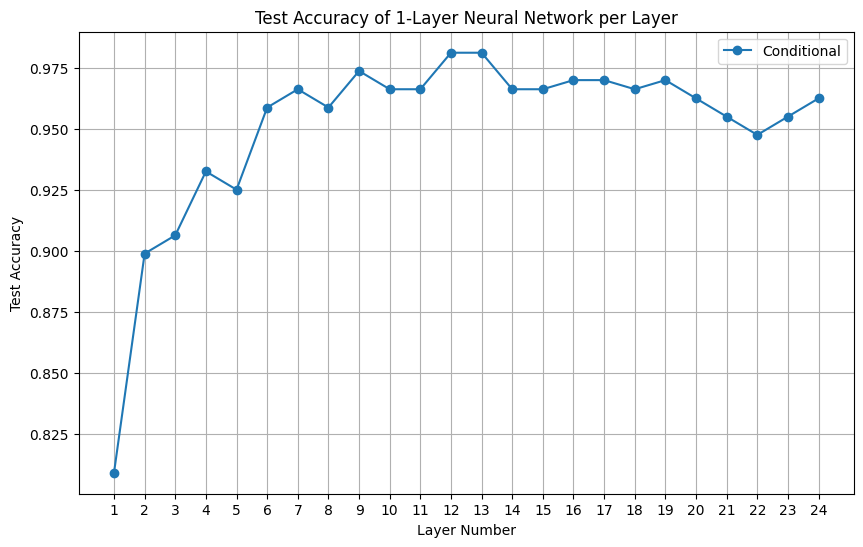

In [82]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(layers, acc_list, label="Conditional", marker="o")
plt.xlabel("Layer Number")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy of 1-Layer Neural Network per Layer")
plt.legend()
plt.grid(True)
plt.xticks(layers)
plt.show()

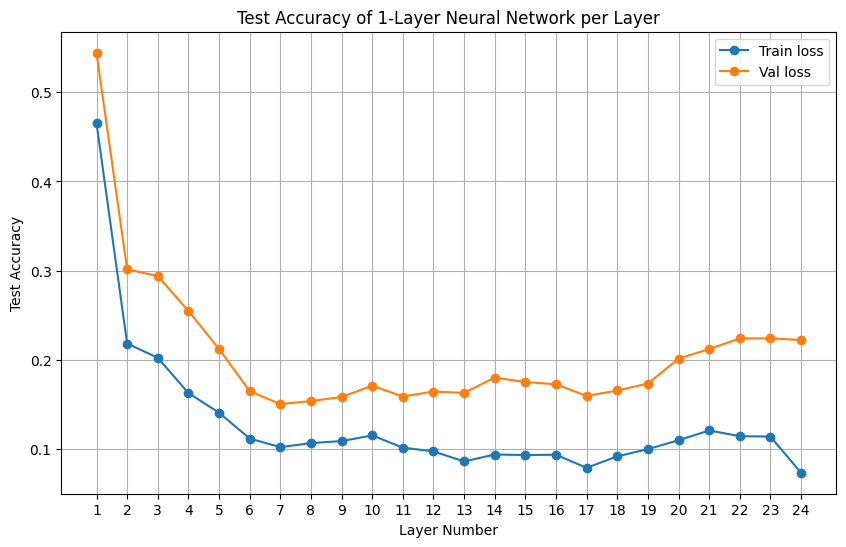

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(layers, loss_list, label="Train loss", marker="o")
plt.plot(layers, vloss_list, label="Val loss", marker="o")
plt.xlabel("Layer Number")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy of 1-Layer Neural Network per Layer")
plt.legend()
plt.grid(True)
plt.xticks(layers)
plt.show()

In [28]:
#classical2rock = [(weights_dict[i][1] - 6*weights_dict[i][0])for i in weights_dict] #Use when using multi-class/ one-hot
classical2rock = [weights_dict[i][0] for i in weights_dict]
print(f"len of classical2rock: {len(classical2rock)}, shape of each element: {classical2rock[0].shape}")

len of classical2rock: 24, shape of each element: (1024,)


In [32]:
np.save('classical_0_rock_1.npy', weights_dict, allow_pickle=True)

In [48]:
cond_weights[1].shape

(10, 1024)

In [125]:
import json
import torch
import numpy as np
from sklearn.decomposition import PCA
from typing import List, Dict
class VectorGuidedMusicgen(MusicgenWithResiduals):
    def __init__(self, model_name="facebook/musicgen-small", device="cuda"):
        super().__init__(model_name=model_name, device=device)
        self.steering_vectors = {}
        self.count=0
        self.freq = 18
    def load_steering_vectors(self, steering_vectors, target_layers):
        """
        Load steering vectors from trained linear probes
        """
        for layer_idx in target_layers:
            steering_vector = steering_vectors[layer_idx-1]
            #steering_vector = probe[target_class].detach()
            steering_vector = steering_vector / np.linalg.norm(steering_vector)
            self.steering_vectors[layer_idx] = torch.Tensor(steering_vector)

        print(f"Loaded steering vectors for layers: {target_layers}")
        print(f"Steering vector shape: {steering_vector.shape}")

    def generate_with_multilayer_guidance(
        self,
        text: Optional[str] = None,
        audio: Optional[torch.Tensor] = None,
        sampling_rate: int = None,
        max_new_tokens: int = 256,
        guidance_scale: float = 3.0,
        target_layers: List[int] = None,
        layer_strengths: Dict[int, float] = None,
        **kwargs
    ):
        if not target_layers:
            target_layers = list(self.steering_vectors.keys())
        if layer_strengths is None:
            print("Layer strengths not set, no steering is done")
            layer_strengths = {layer: 0.0 for layer in target_layers}

        hooks = []
        def create_layer_hook(layer_idx: int, strength: float):
            def residual_hook(module, input, output):
                self.count+=1 #delays the steering between layers if multiple are being steered
                original = output[0]
                device = original.device
                steering_vector = self.steering_vectors[layer_idx].to(device)
                steering_vector = steering_vector.unsqueeze(0)  # [1, hidden_dim]

                cond = original[0]
                uncond = original[1]
                norm = torch.norm(original[0], dim=-1, keepdim=True)
                if self.count%self.freq==0:
                    hidden_state = torch.stack([
                        (cond + norm * steering_vector+strength)/(1 + strength),
                        uncond
                    ])
                else:
                    hidden_state = torch.stack([
                        cond,
                        uncond
                    ])

                return (hidden_state, output[1])

            return residual_hook

        for layer_idx in target_layers:
            strength = layer_strengths.get(layer_idx, 0.0)
            hook_fn = create_layer_hook(layer_idx, strength)
            layer_module = self.model.decoder.model.decoder.layers[layer_idx]
            hook = layer_module.register_forward_hook(hook_fn)
            hooks.append(hook)

        try:
            outputs = super().generate_with_residuals(
                text=text,
                audio=audio,
                sampling_rate=sampling_rate,
                max_new_tokens=max_new_tokens,
                guidance_scale=guidance_scale,
                **kwargs
            )
        finally:
            for hook in hooks:
                hook.remove()

        return outputs


model = VectorGuidedMusicgen()

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading model facebook/musicgen-small to cuda...
Loading processor...
Model ready!


In [141]:
import torchaudio
import librosa
duration=5
#genre_label = 9
target_layers = [12]
#target_class = 2
audio, sr=torchaudio.load("canon_d.wav",normalize=True)
target_sr = 32000

audio = np.array(audio)
audio = librosa.resample(y=audio, orig_sr=sr, target_sr=target_sr)
audio = audio[:, duration*target_sr*3:duration* target_sr*4]
audio = torch.Tensor(audio)
model.count=0
model.freq = 20
if audio.shape[0] == 2:
  audio = torch.mean(audio, dim=0, keepdim=True).squeeze()
print(f'audio shape: {audio.shape}')
model.load_steering_vectors(classical2rock, target_layers)
outputs = model.generate_with_multilayer_guidance(
    text="Pachbel's Canon in D, string quartet, baroque, peaceful, calming",
    audio = audio,
    sampling_rate = target_sr,
    target_layers=target_layers,
    layer_strengths={i: 0.6 for i in target_layers},
    guidance_scale=3.0,
    max_new_tokens = 512
)

audio shape: torch.Size([160000])
Loaded steering vectors for layers: [12]
Steering vector shape: (1024,)


In [142]:
from IPython.display import Audio

audio_values = outputs["audio_values"].detach().cpu().numpy().reshape(-1)
sampling_rate = outputs['sampling_rate']

sample_rate = sampling_rate
Audio(audio_values, rate=sample_rate)

In [53]:
classical = df[df['genre'] == 'classical']
rock = df[df['genre']=='rock']

res_dot_2 = classical['residual_conditional_19'].apply(lambda x: np.dot(x, weights_dict[19][0]))
res_dot_r = rock['residual_conditional_19'].apply(lambda x: np.dot(x, weights_dict[19][0]))

In [55]:
res_dot_r.mean()

5.6508446